In [8]:
#!/usr/bin/env python3
from __future__ import annotations
import argparse
from pathlib import Path
from typing import Optional, Tuple
import itertools
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
NA_VALUES = [
    "", " ", "NA", "N/A", "na", "n/a", "NaN", "nan", "None", "none", "NULL", "null", ".", "-", "?", "missing"
]

CORE_FIELDS_DEFAULT = ["taxonID_index", "Habitat", "Substrate", "Latitude", "Longitude", "eventDate"]

In [10]:
def read_metadata(csv_path: Path, date_col: str, sep: str = ",") -> pd.DataFrame:
    df = pd.read_csv(
        csv_path,
        sep=sep,
        dtype={
            "filename_index": "string",
            "Habitat": "string",
            "Substrate": "string",
            "taxonID_index": "string",
        },
        parse_dates=[date_col],
        infer_datetime_format=True,
        keep_date_col=False,
        na_values=NA_VALUES,
        keep_default_na=True,
    )

    # Strip whitespace in string columns
    for c in df.select_dtypes(include="string").columns:
        df[c] = df[c].str.strip()

    # Coerce coords
    for c in ("Latitude", "Longitude"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    return df


def filter_split(df: pd.DataFrame, split: str, id_col: str = "filename_index") -> pd.DataFrame:
    if split == "all":
        return df
    prefix = f"fungi_{split}"
    keep = df[id_col].str.startswith(prefix, na=False)
    return df[keep].copy()


In [11]:


def basic_missingness(df: pd.DataFrame) -> pd.DataFrame:
    n = len(df)
    rows = []
    for c in df.columns:
        nn = df[c].notna().sum()
        na = n - nn
        uniq = df[c].nunique(dropna=True)
        example = None
        if nn > 0:
            example = df.loc[df[c].notna(), c].iloc[0]
            if isinstance(example, pd.Timestamp):
                example = str(example.date())
            else:
                example = str(example)[:60]
        rows.append((c, nn, na, (na / n * 100) if n else 0.0, uniq, example))
    out = pd.DataFrame(rows,
                       columns=["column", "non_null", "missing", "missing_pct", "unique_non_null", "example_non_null"])
    return out.sort_values("missing_pct", ascending=False)


def row_completeness(df: pd.DataFrame, exclude: list[str]) -> pd.Series:
    cols = [c for c in df.columns if c not in exclude]
    return df[cols].notna().mean(axis=1)  # fraction of non-null per row


def per_class_coverage(df: pd.DataFrame, class_col: str, key_fields: list[str]) -> pd.DataFrame:
    def cov(g: pd.DataFrame) -> dict:
        d = {"count": len(g)}
        for k in key_fields:
            if k in g.columns:
                d[f"{k}__non_null"] = g[k].notna().sum()
                d[f"{k}__coverage_pct"] = g[k].notna().mean() * 100
            else:
                d[f"{k}__non_null"] = np.nan
                d[f"{k}__coverage_pct"] = np.nan
        return d

    blocks = []
    for cls, g in df.groupby(class_col, dropna=False):
        info = cov(g)
        info[class_col] = cls if pd.notna(cls) else "⟂(missing)"
        blocks.append(info)
    out = pd.DataFrame(blocks).set_index(class_col).sort_values("count", ascending=False)
    return out


def coord_quality(df: pd.DataFrame) -> pd.DataFrame:
    if not {"Latitude", "Longitude"}.issubset(df.columns):
        return pd.DataFrame()
    lat_ok = df["Latitude"].between(-90, 90, inclusive="both")
    lon_ok = df["Longitude"].between(-180, 180, inclusive="both")
    status = np.where(df["Latitude"].isna() | df["Longitude"].isna(), "missing",
                      np.where(lat_ok & lon_ok, "valid", "invalid"))
    return pd.Series(status, name="coord_status").value_counts().rename_axis("status").to_frame("count")


def pairwise_missingness(df: pd.DataFrame, consider_cols: Optional[list[str]] = None) -> pd.DataFrame:
    if consider_cols is None:
        consider_cols = [c for c in df.columns if c != "filename_index"]
    n = len(df)
    pairs = []
    for a, b in itertools.combinations(consider_cols, 2):
        both_na = (df[a].isna() & df[b].isna()).sum()
        pairs.append((a, b, both_na, (both_na / n * 100) if n else 0.0))
    if not pairs:
        return pd.DataFrame()
    return pd.DataFrame(pairs, columns=["col_a", "col_b", "both_missing", "both_missing_pct"]).sort_values(
        "both_missing_pct", ascending=False)


def safe_bar(series: pd.Series, title: str, xlabel: str, ylabel: str, out: str, wrap_width: int = 20):
    plt.figure(figsize=(16, 10))  # widen + dynamic height
    # Wrap index labels if they're too long
    labels = [textwrap.fill(str(lbl), wrap_width) for lbl in series.index]
    series.index = labels

    ax = series.plot(kind="bar")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")  # rotate for readability
    plt.tight_layout()
    plt.savefig(out + "/" + title + ".png")


def safe_hist(values: pd.Series, title: str, xlabel: str, ylabel: str, out: str, bins: int = 20):
    plt.figure()
    plt.hist(values.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(out + "/" + title + ".png")


# --- Add alongside your other helpers ---

def safe_scatter(x: pd.Series, y: pd.Series, title: str, xlabel: str, ylabel: str, out: str):
    plt.figure()
    plt.scatter(x, y, s=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(out + "/" + title + ".png")


def value_counts_nomiss(s: pd.Series) -> pd.Series:
    return (
        s.astype("string").str.strip().replace("", pd.NA).dropna().value_counts()
    )



In [12]:
import os

df = read_metadata("data/metadata.csv", date_col="eventDate", sep=",")
test = filter_split(df, "test", id_col="filename_index")
train = filter_split(df, "train", id_col="filename_index")

train_output_path = "report_train"
test_output_path = "report_test"

os.makedirs(train_output_path, exist_ok=True)
os.makedirs(test_output_path, exist_ok=True)


/tmp/ipykernel_185118/3484572476.py:2: FutureWarning: The 'keep_date_col' keyword in pd.read_csv is deprecated and will be removed in a future version. Explicitly remove unwanted columns after parsing instead.
  df = pd.read_csv(
/tmp/ipykernel_185118/3484572476.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


In [13]:
train.head(20)

,filename_index,Habitat,Latitude,Longitude,Substrate,eventDate,taxonID_index
10152,fungi_train000000.jpg,<NA>,NaN,NaN,<NA>,NaT,66
10153,fungi_train000001.jpg,<NA>,NaN,NaN,<NA>,NaT,174
10154,fungi_train000002.jpg,<NA>,NaN,NaN,<NA>,NaT,50
10155,fungi_train000003.jpg,<NA>,NaN,NaN,<NA>,NaT,72
10156,fungi_train000004.jpg,<NA>,NaN,NaN,<NA>,NaT,30
10157,fungi_train000005.jpg,<NA>,NaN,NaN,soil,NaT,66
10158,fungi_train000006.jpg,<NA>,NaN,NaN,<NA>,NaT,70
10159,fungi_train000007.jpg,<NA>,NaN,NaN,<NA>,NaT,113
10160,fungi_train000008.jpg,<NA>,NaN,NaN,<NA>,NaT,37
10161,fungi_train000009.jpg,<NA>,NaN,NaN,<NA>,NaT,180


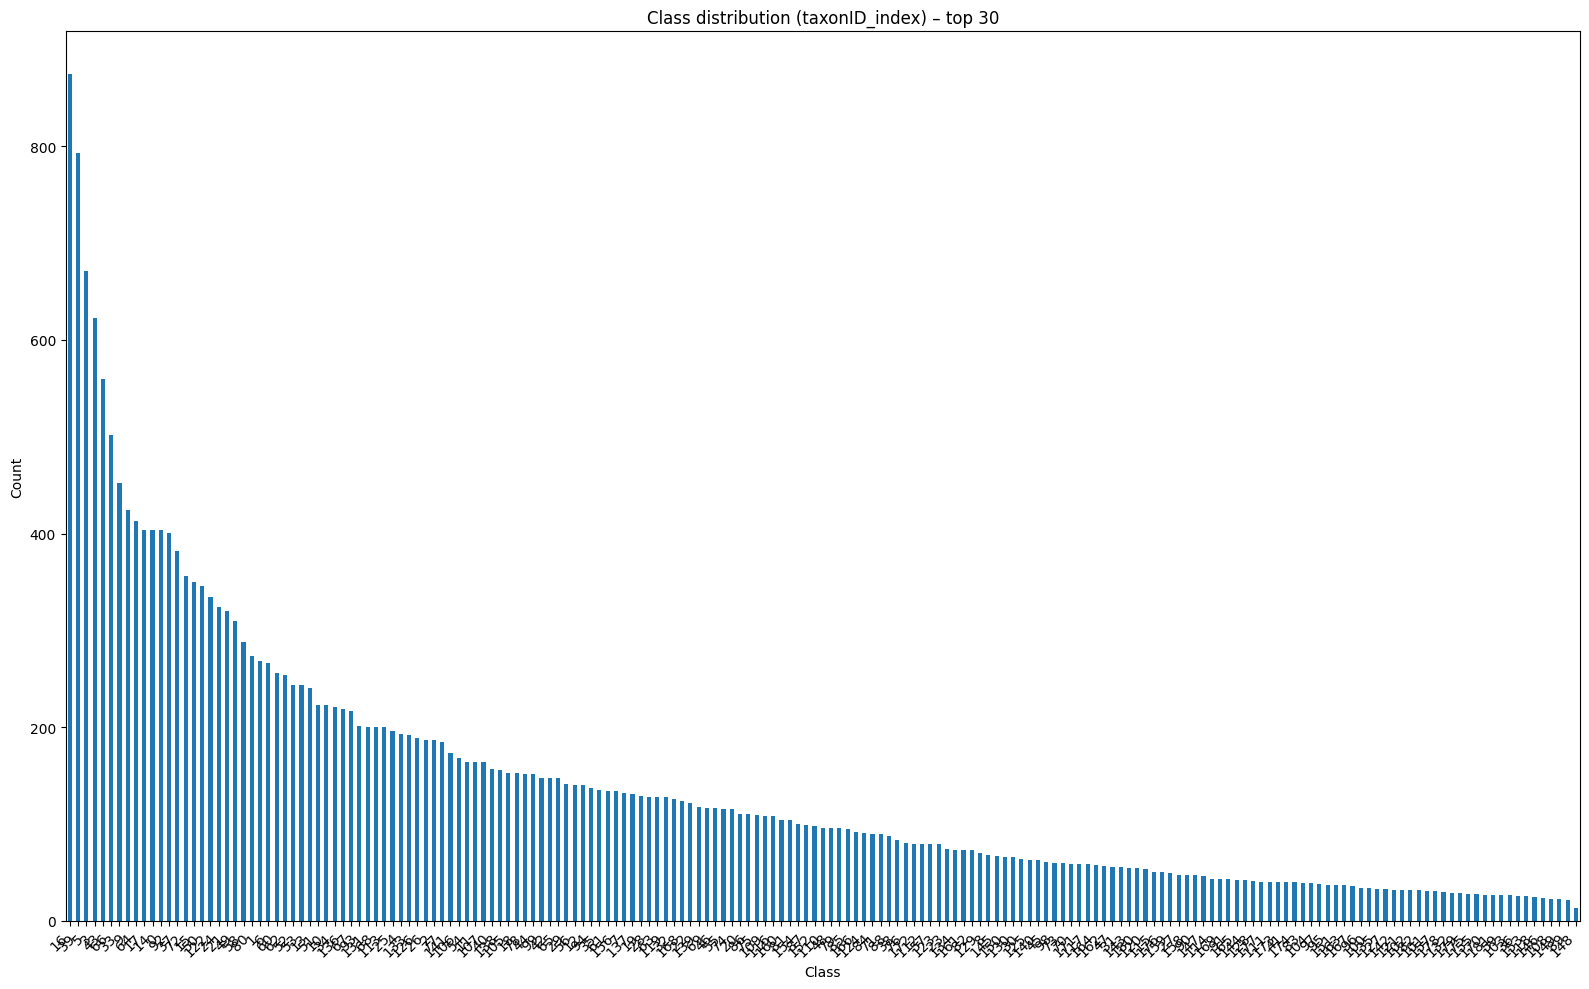

In [14]:
 # Class distribution
class_counts = value_counts_nomiss(train["taxonID_index"])
if len(class_counts) > 0:
    safe_bar(
        class_counts.head(200),
        "Class distribution (taxonID_index) – top 30",
        "Class",
        "Count",
        train_output_path
    )

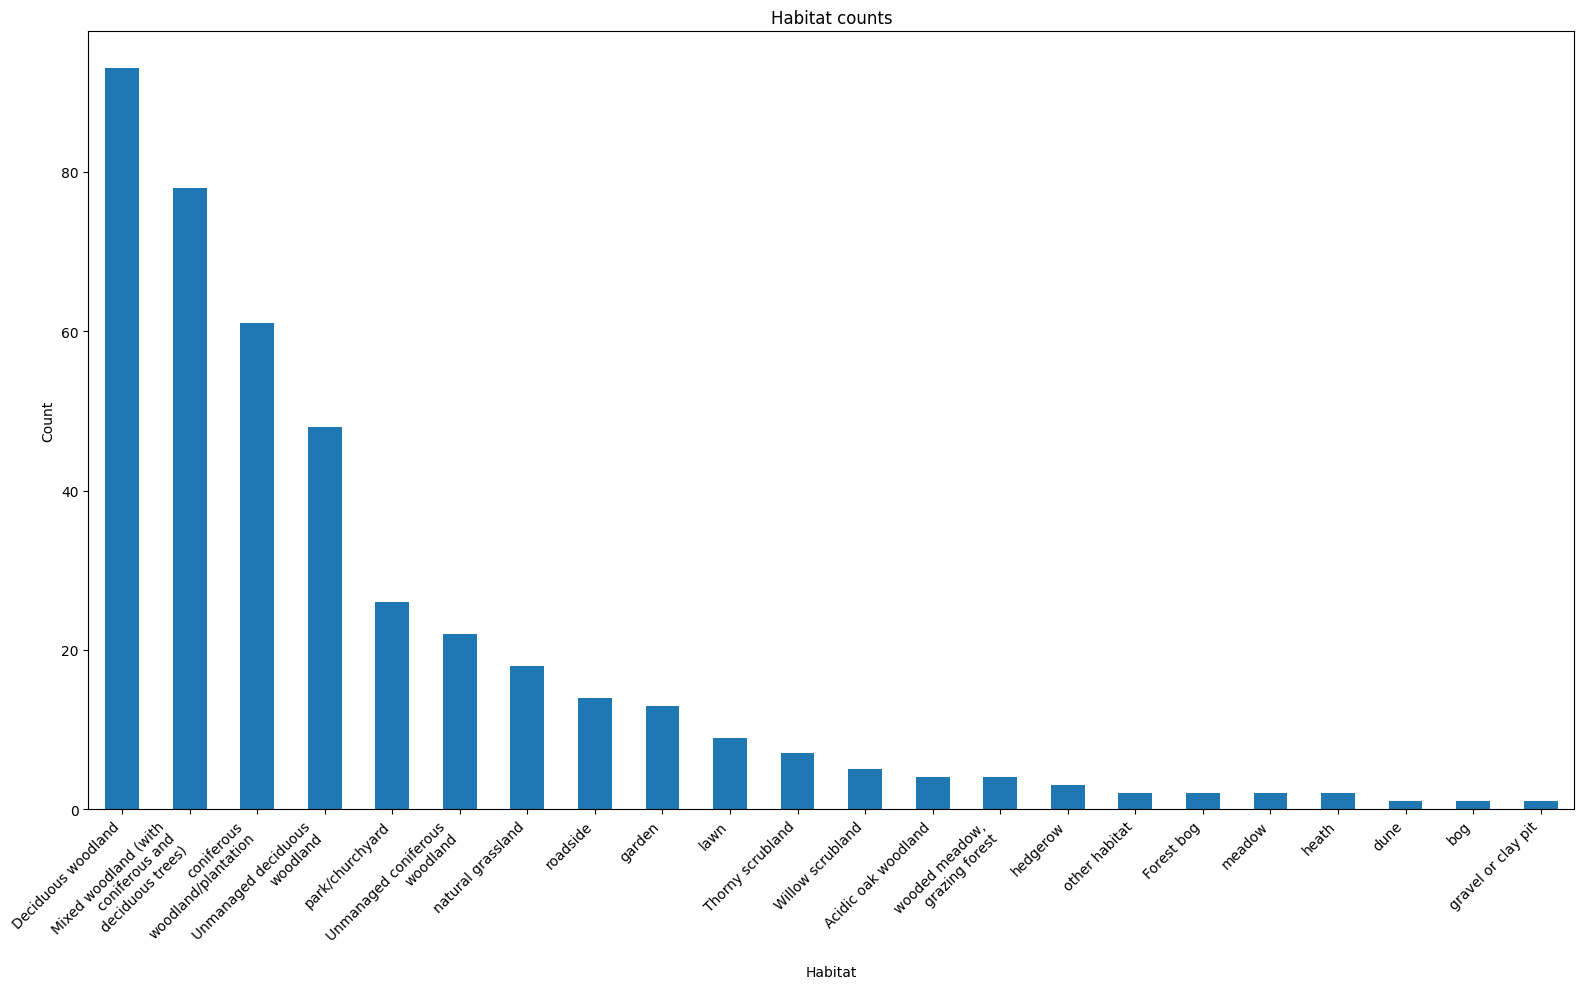

In [15]:
habitat_counts = value_counts_nomiss(train["Habitat"])
if len(habitat_counts) > 0:
    safe_bar(
        habitat_counts,
        "Habitat counts",
        "Habitat",
        "Count",
        train_output_path
    )


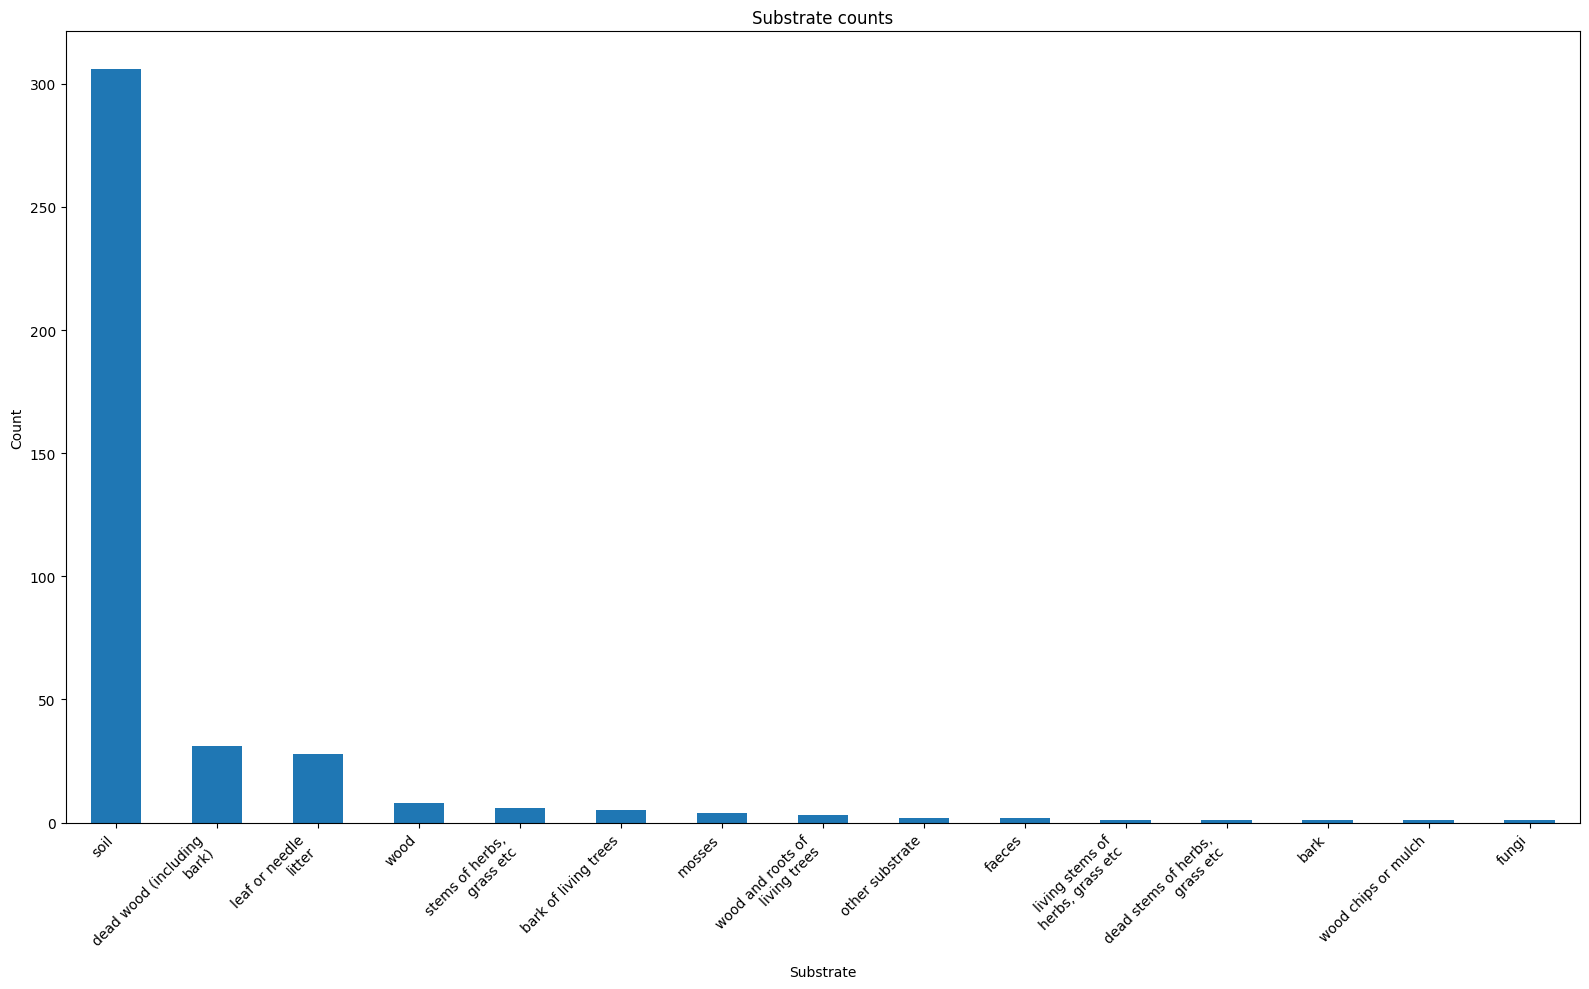

In [16]:
substrate_counts = value_counts_nomiss(train["Substrate"])
if len(substrate_counts) > 0:
    safe_bar(
        substrate_counts,
        "Substrate counts",
        "Substrate",
        "Count",
        train_output_path
    )

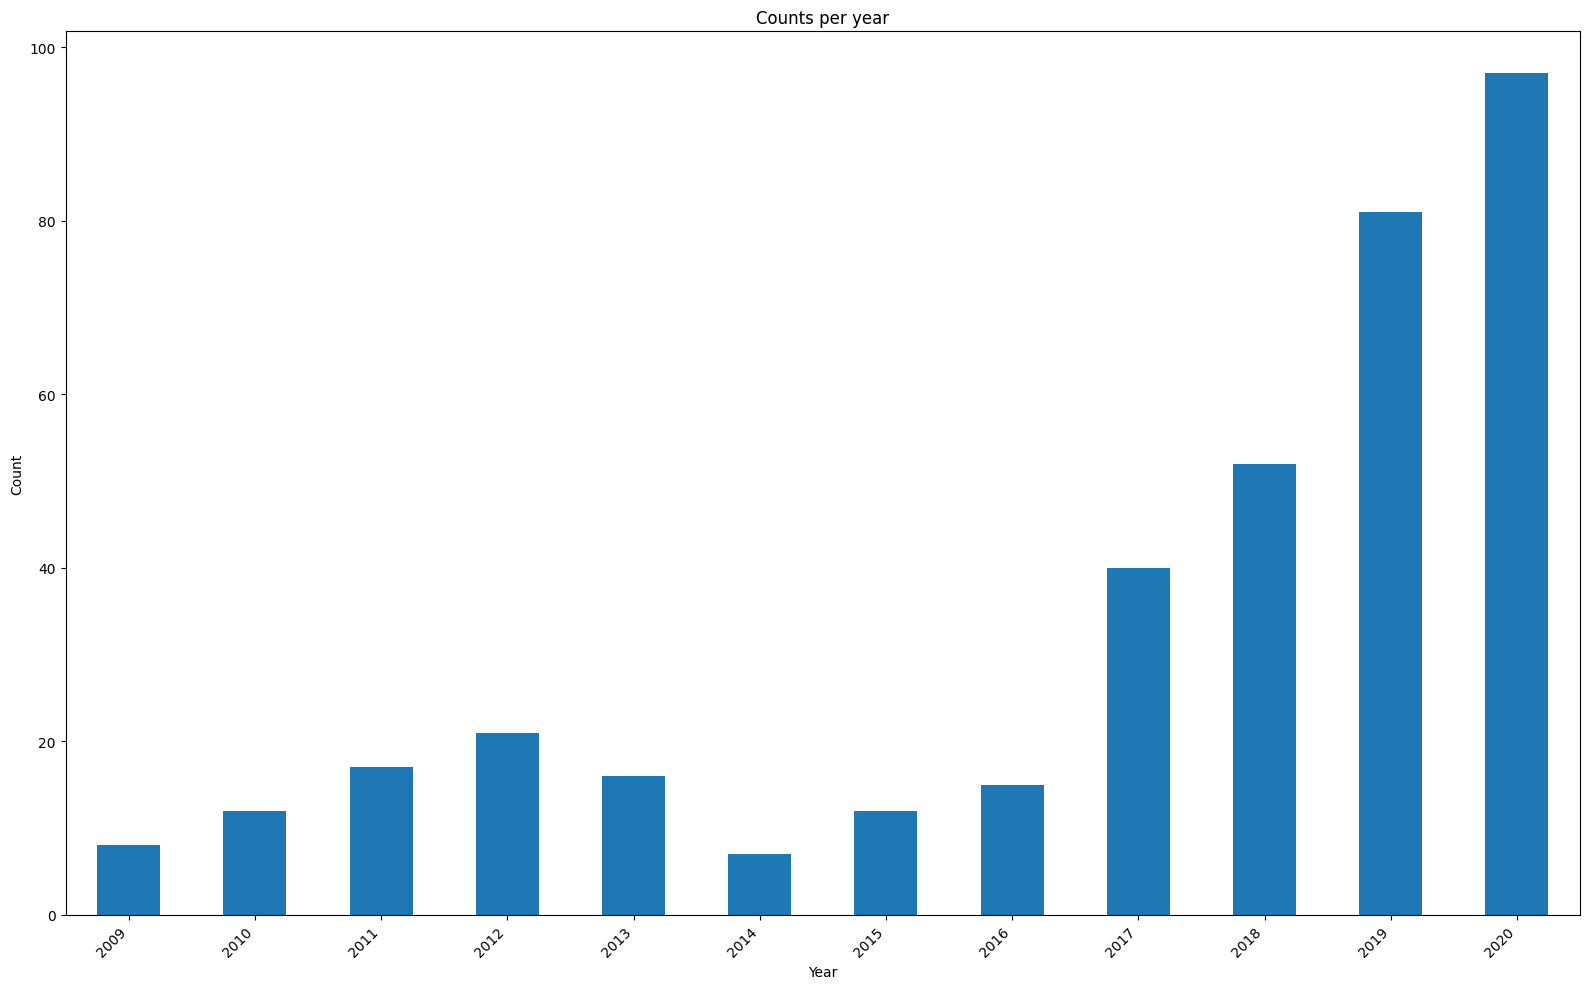

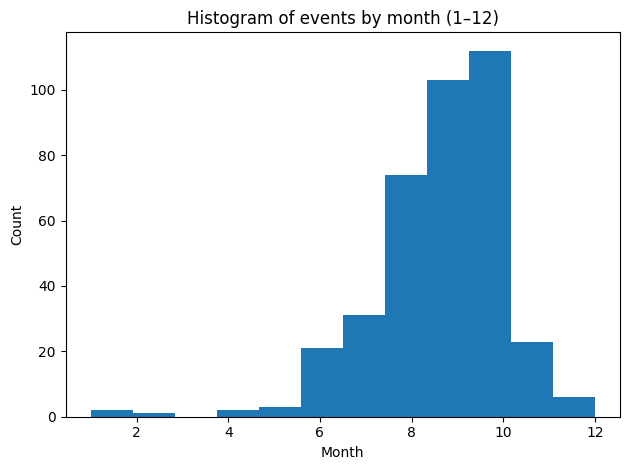

In [17]:
years = train["eventDate"].dt.year.dropna().astype("Int64")
if len(years) > 0:
    year_counts = years.value_counts().sort_index()
    safe_bar(
        year_counts,
        "Counts per year",
        "Year",
        "Count",
        train_output_path
    )

    months = train["eventDate"].dt.month.dropna().astype("Int64")
    if len(months) > 0:
        safe_hist(
            months,
            "Histogram of events by month (1–12)",
            "Month",
            "Count",
            train_output_path,
            bins=12,
        )


In [18]:
train.head(20)

,filename_index,Habitat,Latitude,Longitude,Substrate,eventDate,taxonID_index
10152,fungi_train000000.jpg,<NA>,NaN,NaN,<NA>,NaT,66
10153,fungi_train000001.jpg,<NA>,NaN,NaN,<NA>,NaT,174
10154,fungi_train000002.jpg,<NA>,NaN,NaN,<NA>,NaT,50
10155,fungi_train000003.jpg,<NA>,NaN,NaN,<NA>,NaT,72
10156,fungi_train000004.jpg,<NA>,NaN,NaN,<NA>,NaT,30
10157,fungi_train000005.jpg,<NA>,NaN,NaN,soil,NaT,66
10158,fungi_train000006.jpg,<NA>,NaN,NaN,<NA>,NaT,70
10159,fungi_train000007.jpg,<NA>,NaN,NaN,<NA>,NaT,113
10160,fungi_train000008.jpg,<NA>,NaN,NaN,<NA>,NaT,37
10161,fungi_train000009.jpg,<NA>,NaN,NaN,<NA>,NaT,180


In [19]:
from pathlib import Path
import pandas as pd


def plot_class_hists_by_substrate(
        df: pd.DataFrame,
        substrate_col: str = "Substrate",
        class_col: str = "taxonID_index",
        out_dir: str | Path = "report",
        top_classes: int | None = None,  # e.g., 50 to reduce clutter
        drop_unknown: bool = False,  # True to skip Unknown substrates
        min_samples: int = 1  # skip tiny groups
):
    data = df[[substrate_col, class_col]].copy()
    # keep valid class labels
    data = data[data[class_col].notna()]
    data[class_col] = data[class_col].astype(int)

    # normalize substrate names
    data[substrate_col] = (
        data[substrate_col]
        .astype("string")
        .fillna("Unknown")
        .replace({"<NA>": "Unknown"})
    )

    if drop_unknown:
        data = data[data[substrate_col] != "Unknown"]

    # (optional) focus on top-N classes globally
    if top_classes is not None:
        top = data[class_col].value_counts().head(top_classes).index
        data = data[data[class_col].isin(top)]

    # one plot per substrate
    for sub, sub_df in sorted(data.groupby(substrate_col)):
        if len(sub_df) < min_samples:
            continue
        counts = sub_df[class_col].value_counts().sort_index()

        title = f"{class_col} distribution — Substrate: {sub} (n={len(sub_df)})"
        safe_bar(
            counts,
            title,
            "Class index",
            "Count",
            out_dir
        )


# Example (using your train split + train_output_path)
#plot_class_hists_by_substrate(train, out_dir=train_output_path, top_classes=None, drop_unknown=False)


In [20]:
from pathlib import Path
import pandas as pd


def plot_class_hists_by_habitat(
        df: pd.DataFrame,
        habitat_col: str = "Habitat",
        class_col: str = "taxonID_index",
        out_dir: str | Path = "report",
        top_classes: int | None = None,  # e.g., 50 to reduce clutter
        drop_unknown: bool = False,  # True to skip Unknown habitat
        min_samples: int = 1  # skip tiny groups
):
    data = df[[habitat_col, class_col]].copy()
    # keep valid class labels
    data = data[data[class_col].notna()]
    data[class_col] = data[class_col].astype(int)

    # normalize habitat names
    data[habitat_col] = (
        data[habitat_col]
        .astype("string")
        .fillna("Unknown")
        .replace({"<NA>": "Unknown"})
    )

    if drop_unknown:
        data = data[data[habitat_col] != "Unknown"]

    # (optional) focus on top-N classes globally
    if top_classes is not None:
        top = data[class_col].value_counts().head(top_classes).index
        data = data[data[class_col].isin(top)]

    # one plot per habitat
    for hab, hab_df in sorted(data.groupby(habitat_col)):
        if len(hab_df) < min_samples:
            continue
        counts = hab_df[class_col].value_counts().sort_index()
        print(f"Habitat Name: {hab}, Counts: {counts}")

        title = f"{class_col} distribution — Habitat: {hab} (n={len(hab_df)})"
        safe_bar(counts, title, "Class index", "Count", out_dir)


# Example (using your train split + train_output_path)
#plot_class_hists_by_habitat(train, out_dir=train_output_path, top_classes=None, drop_unknown=False)



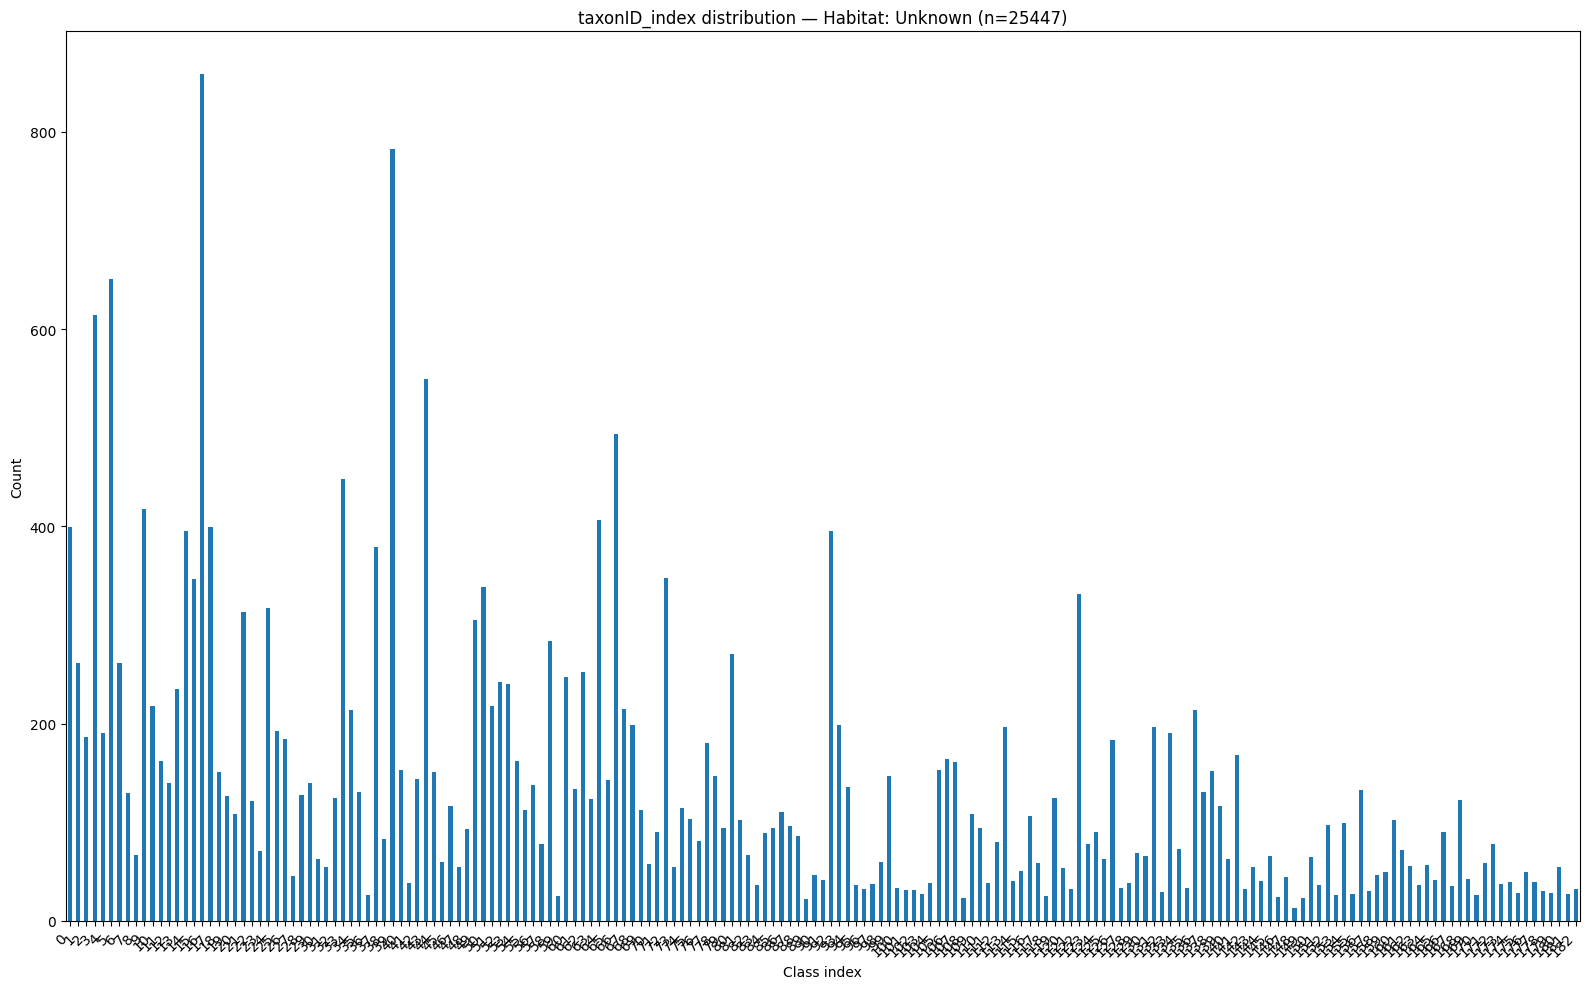

In [21]:

train_habitat = df[["Habitat", "taxonID_index"]].copy()
# keep valid class labels
train_habitat = train_habitat[train_habitat["taxonID_index"].notna()]
train_habitat["taxonID_index"] = train_habitat["taxonID_index"].astype(int)

# normalize habitat names
train_habitat["Habitat"] = (
train_habitat["Habitat"]
.astype("string")
.fillna("Unknown")
.replace({"<NA>": "Unknown"})
)


# one plot per habitat
for hab, hab_df in sorted(train_habitat.groupby("Habitat")):
    if "Unknown" not in hab:
        continue
    counts = hab_df["taxonID_index"].value_counts().sort_index()
    title = f"{"taxonID_index"} distribution — Habitat: {hab} (n={len(hab_df)})"
    safe_bar(counts, title, "Class index", "Count", train_output_path)

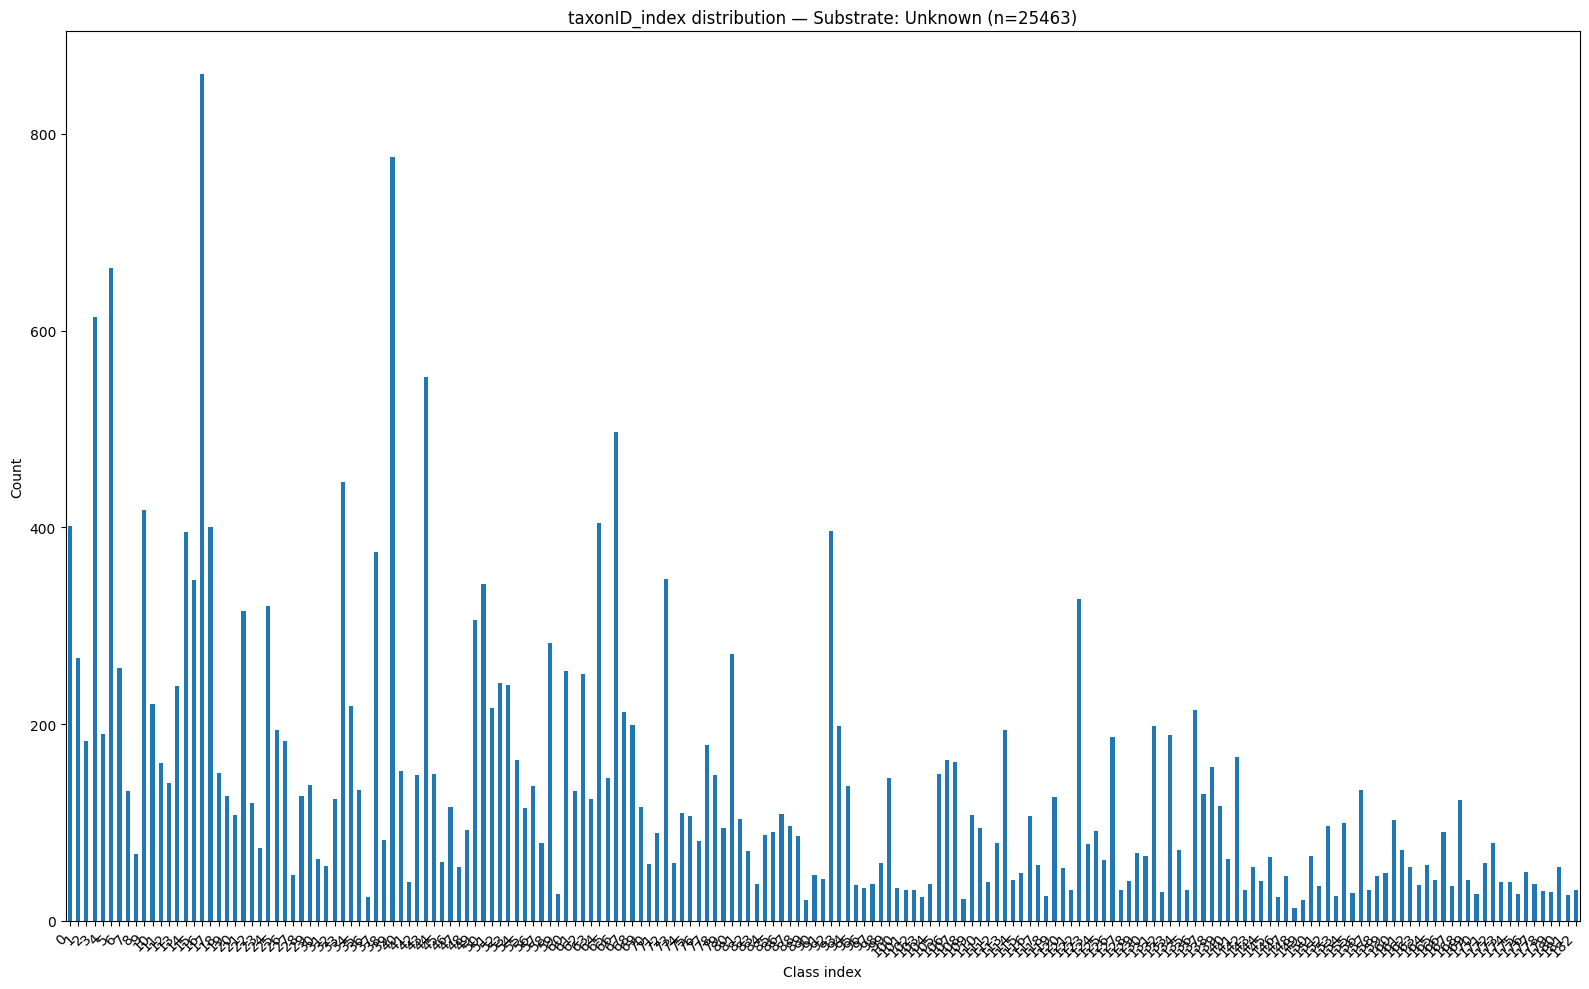

In [22]:

train_substrate = df[["Substrate", "taxonID_index"]].copy()
# keep valid class labels
train_substrate = train_substrate[train_substrate["taxonID_index"].notna()]
train_substrate["taxonID_index"] = train_substrate["taxonID_index"].astype(int)

# normalize habitat names
train_substrate["Substrate"] = (
    train_substrate["Substrate"]
    .astype("string")
    .fillna("Unknown")
    .replace({"<NA>": "Unknown"})
)


# one plot per habitat
for hab, hab_df in sorted(train_substrate.groupby("Substrate")):
    if "Unknown" not in hab:
        continue
    counts = hab_df["taxonID_index"].value_counts().sort_index()
    title = f"{"taxonID_index"} distribution — Substrate: {hab} (n={len(hab_df)})"
    safe_bar(counts, title, "Class index", "Count", train_output_path)
    
    ## Normalize wrt to number of entries in the class. I.e. what percentage of the total class has missing substrate entry
    

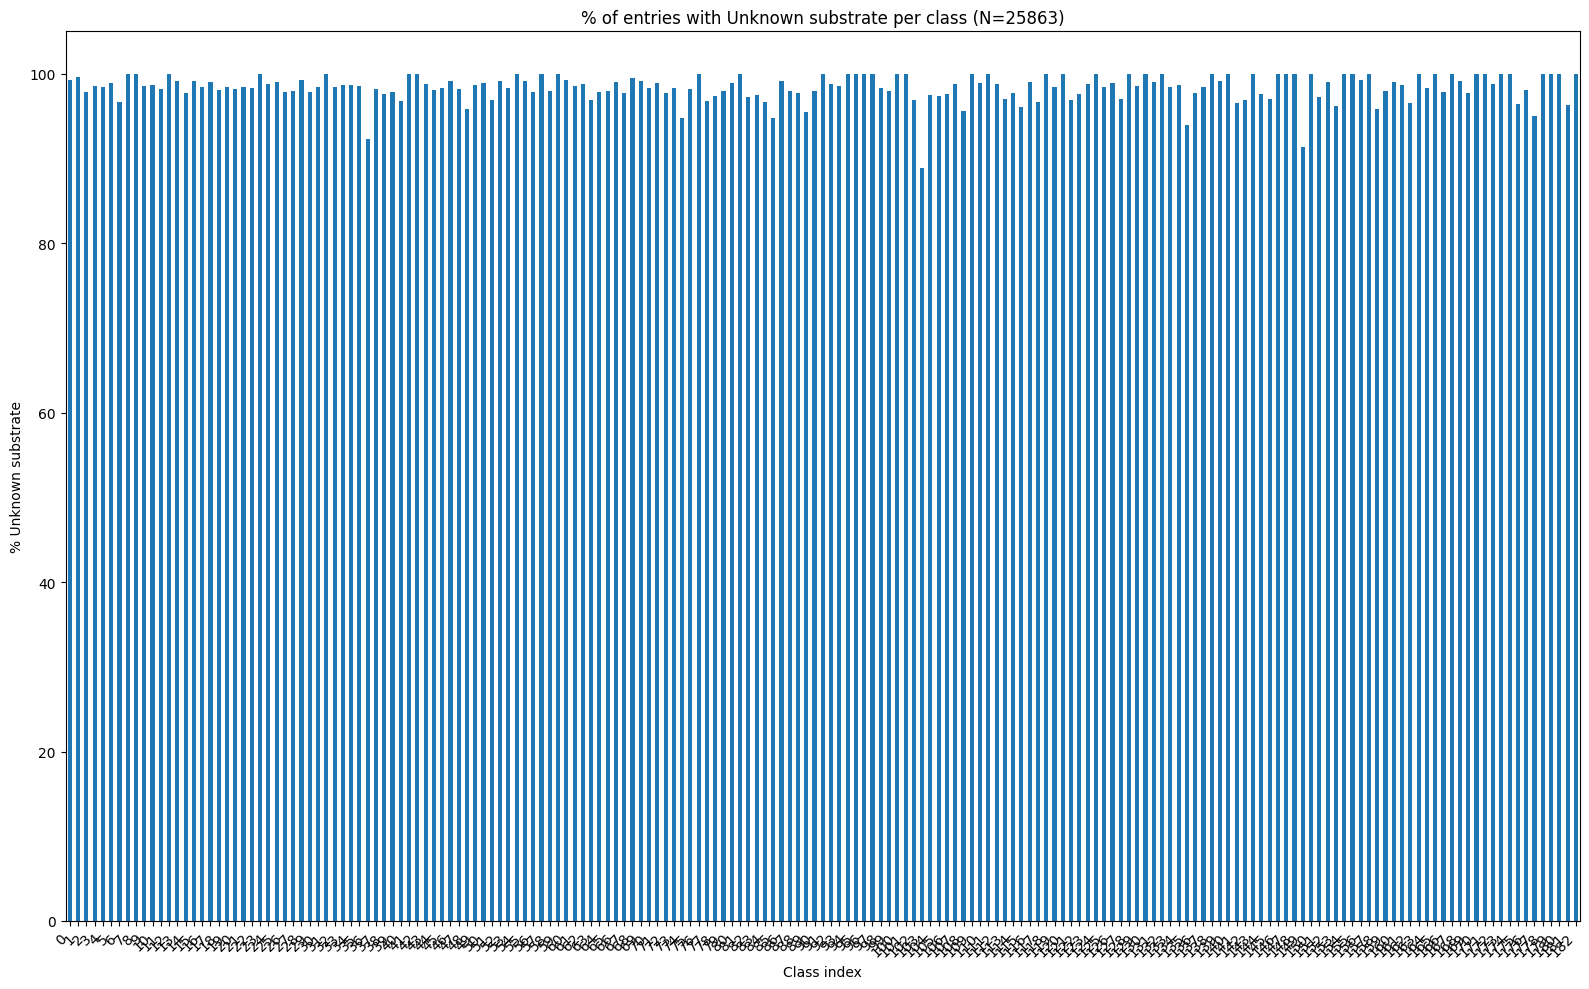

In [23]:
train_substrate = df[["Substrate", "taxonID_index"]].copy()
train_substrate = train_substrate[train_substrate["taxonID_index"].notna()]
train_substrate["taxonID_index"] = train_substrate["taxonID_index"].astype(int)

# normalize names
train_substrate["Substrate"] = (
    train_substrate["Substrate"]
    .astype("string")
    .fillna("Unknown")
    .replace({"<NA>": "Unknown"})
)

# totals per class (denominator)
class_totals = train_substrate["taxonID_index"].value_counts()

# rows considered "Unknown" substrate
unknown_mask = train_substrate["Substrate"].str.contains("Unknown", case=False, na=False)
unknown_counts = train_substrate.loc[unknown_mask, "taxonID_index"].value_counts()

# percentage of each class that is Unknown
unknown_pct = (unknown_counts / class_totals).reindex(class_totals.index, fill_value=0).sort_index() * 100

title = f"% of entries with Unknown substrate per class (N={len(train_substrate)})"
safe_bar(unknown_pct, title, "Class index", "% Unknown substrate", train_output_path)


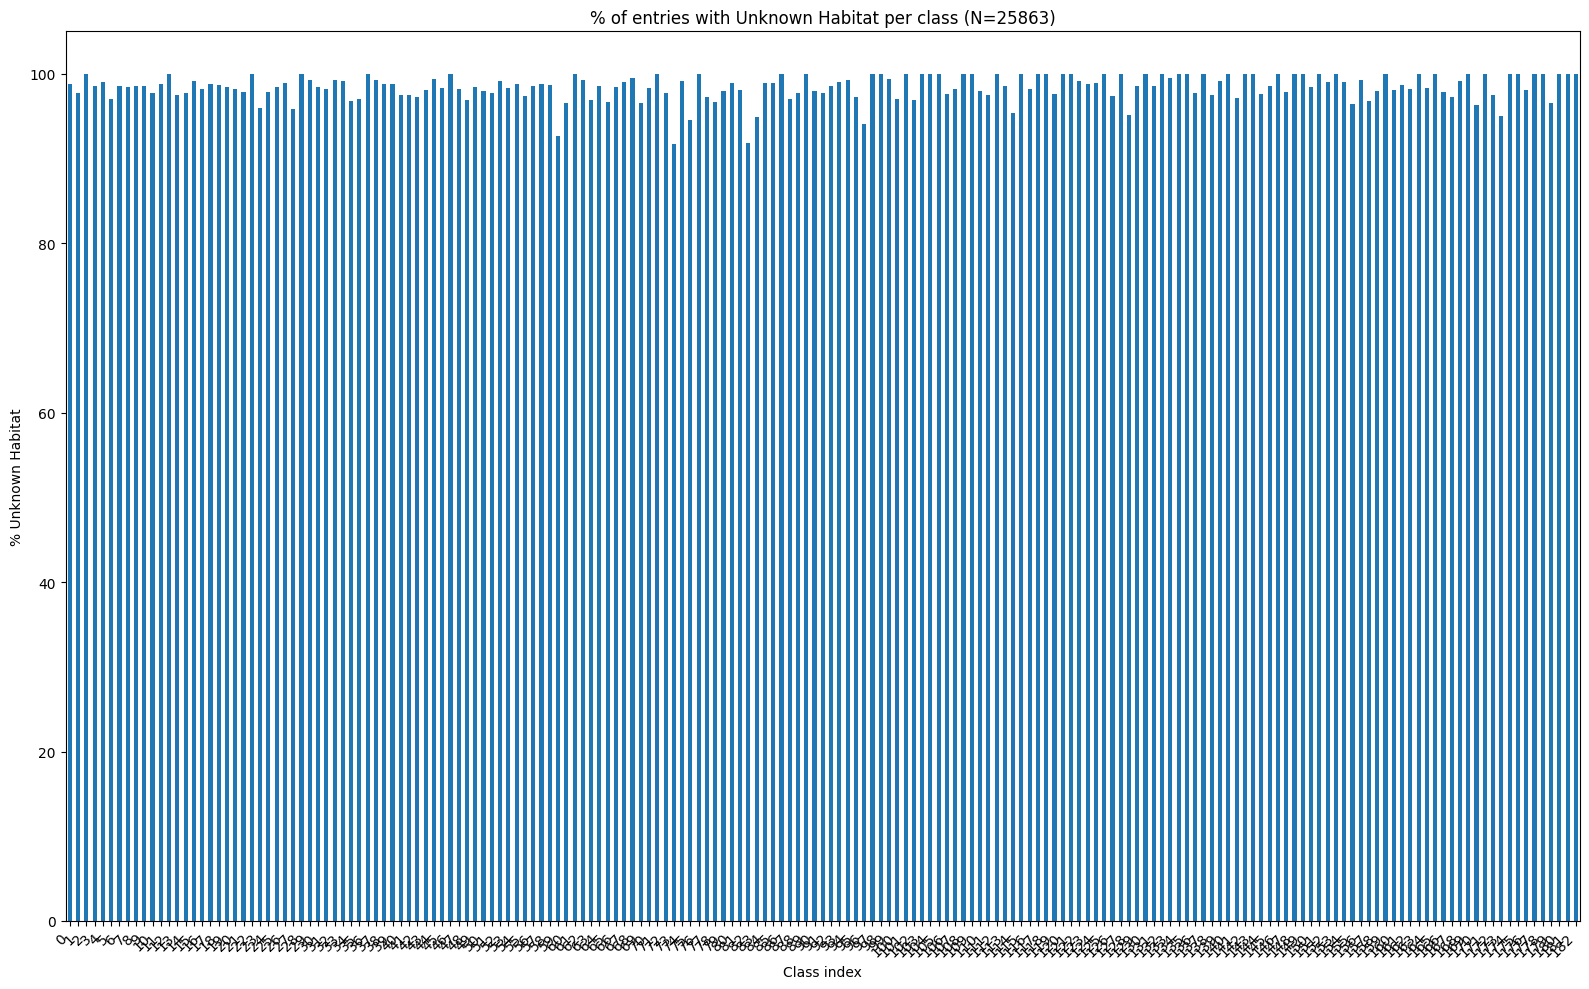

In [24]:
train_habitat = df[["Habitat", "taxonID_index"]].copy()
train_habitat = train_habitat[train_habitat["taxonID_index"].notna()]
train_habitat["taxonID_index"] = train_habitat["taxonID_index"].astype(int)

# normalize names
train_habitat["Habitat"] = (
    train_habitat["Habitat"]
    .astype("string")
    .fillna("Unknown")
    .replace({"<NA>": "Unknown"})
)

# totals per class (denominator)
class_totals = train_habitat["taxonID_index"].value_counts()

# rows considered "Unknown" Habitat
unknown_mask = train_habitat["Habitat"].str.contains("Unknown", case=False, na=False)
unknown_counts = train_habitat.loc[unknown_mask, "taxonID_index"].value_counts()

# percentage of each class that is Unknown
unknown_pct = (unknown_counts / class_totals).reindex(class_totals.index, fill_value=0).sort_index() * 100

title = f"% of entries with Unknown Habitat per class (N={len(train_habitat)})"
safe_bar(unknown_pct, title, "Class index", "% Unknown Habitat", train_output_path)
